In [44]:
import mne
import pyedflib
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy import signal

In [2]:
# %matplotlib osx

In [3]:
download = False
if download:
    patient_code = "chb01"
    filename = "chb01_04.edf"
    url = "https://physionet.org/files/chbmit/1.0.0/" + patient_code + "/" + filename
    savetopath = "data/" + patient_code + "/" + filename
    print("Requesting file:", url)
    urlretrieve(url, savetopath)
    print("Download complete.\nSaved to:", savetopath)

In [4]:
filepath = 'data/chb01/chb01_04.edf'
f = pyedflib.EdfReader(filepath)
n = f.signals_in_file
signal_labels = f.getSignalLabels()
sigbufs = np.zeros((n, f.getNSamples()[0]))
for i in np.arange(n):
    sigbufs[i, :] = f.readSignal(i)

ch_names = f.getSignalLabels()
ch_freqs = f.getSampleFrequencies()
f.close()

In [5]:
# transform channel names to standard 10/20 system
# ch_names = []
# for ch_name in ch_names_raw:
#     ch_names.append(ch_name.split('-')[0].title())
# # remove duplicates
# ch_names = list(set(ch_names))
# ch_names

In [6]:
# assume sampling frequency is the same for all channels as they usually are
fs = ch_freqs[0]
fs

256

In [7]:
info = mne.create_info(ch_names, sfreq=fs, ch_types='eeg')
print(info)

<Info | 7 non-empty values
 bads: []
 ch_names: FP1-F7, F7-T7, T7-P7, P7-O1, FP1-F3, F3-C3, C3-P3, P3-O1, ...
 chs: 23 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 128.0 Hz
 meas_date: unspecified
 nchan: 23
 projs: []
 sfreq: 256.0 Hz
>


<ipython-input-7-55257dd93506>:1: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  info = mne.create_info(ch_names, sfreq=fs, ch_types='eeg')


In [8]:
# convert from microvolt to volt.
# this is because EEG is measured in microvolt
# but mne wants its input EEG signal in volts
fun = lambda x: x/1e+6
data = fun(sigbufs)

In [9]:
raw = mne.io.RawArray(data, info)

Creating RawArray with float64 data, n_channels=23, n_times=921600
    Range : 0 ... 921599 =      0.000 ...  3599.996 secs
Ready.


In [10]:
# set seizure annotation
start_time = np.array([1467.0])
anno_len = 27.0
event_desc = 'Seizure'
raw.set_annotations(mne.Annotations(start_time, anno_len, event_desc))
print(event_desc + " annotation added")

Seizure annotation added


In [11]:
# set plot parameters
plot_kwargs = {
    'scalings': dict(eeg=20e-5),   # zooms the plot out
}

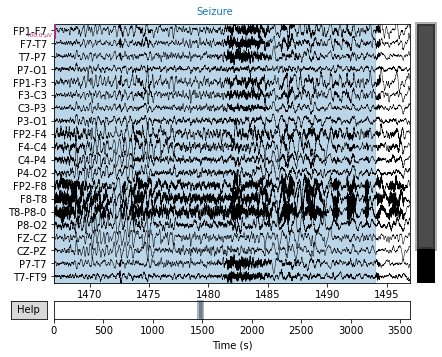

In [12]:
# plot seizure
# start: 1467s, end: 1494s
plot = raw.plot(start=1467.0, duration=30.0, title="chb01_04.edf", **plot_kwargs)

**Comments**

- Why are there duplicate channels?
- What should be done with them?

In [13]:
# F8-T8 exhibits fast rhythmic activity during seizure.
# select this channel
idxes = raw.time_as_index([1467, 1494])
print(idxes)
picked = raw.get_data('F8-T8', start=idxes[0], stop=idxes[1])
print(type(picked))
print(picked.shape)

[375552 382464]
<class 'numpy.ndarray'>
(1, 6912)


(-0.004, 0.004)

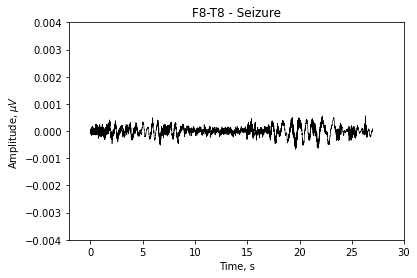

In [74]:
# plot this channel
ch = picked.T
N = len(ch)
t = np.arange(0, N) / fs
fig, ax = plt.subplots()
ax.plot(t, ch, color='k', linewidth=.6)
ax.set_title('F8-T8 - Seizure')
ax.set_xlabel('Time, s')
ax.set_ylabel('Amplitude, $\mu V$')
ax.set_xlim([-2,30])
ax.set_ylim([-0.004, 0.004])

In [77]:
ch = ch.reshape(-1,)

In [78]:
ch.shape

(6912,)

Text(0, 0.5, '$\\log_{10}$ Power')

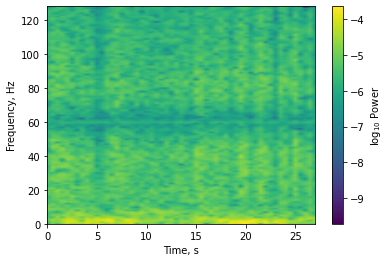

In [57]:
# produce spectrogram of the 30s seizure period using
# STFT with 1s sliding Hann window.
timewin = 1 # in seconds
timewinidx = np.round(timewin/(1/fs)).astype(int)

f, t, Zxx = signal.stft(ch, fs=fs, window='hann', 
                        nperseg=timewinidx, noverlap=None, nfft=None,
                        detrend='linear', return_onesided=True)

fig, ax = plt.subplots()
mesh = ax.pcolormesh(t, f, np.log10(np.abs(Zxx)), shading='gouraud')
ax.set_xlabel('Time, s')
ax.set_ylabel('Frequency, Hz')
cbar = fig.colorbar(mesh)
cbar.ax.set_ylabel('$\log_{10}$ Power')

In [79]:
ch.shape

(6912,)

Text(0, 0.5, '$\\log_{10}$ Power')

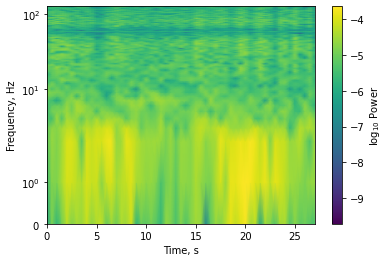

In [80]:
# produce spectrogram of the 30s seizure period using
# STFT with 1s sliding Hann window.
timewin = 1 # in seconds
timewinidx = np.round(timewin/(1/fs)).astype(int)

f, t, Zxx = signal.stft(ch, fs=fs, window='hann', 
                        nperseg=timewinidx, noverlap=None, nfft=None,
                        detrend='linear', return_onesided=True)

fig, ax = plt.subplots()
mesh = ax.pcolormesh(t, f, np.log10(np.abs(Zxx)), shading='gouraud')
ax.set_xlabel('Time, s')
ax.set_ylabel('Frequency, Hz')
ax.set_yscale('symlog')
# ax.set_ylim([np.min(f) + 1, np.max(f)])
cbar = fig.colorbar(mesh)
cbar.ax.set_ylabel('$\log_{10}$ Power')

In [56]:
np.log10(np.abs(Zxx)).shape

(129, 55)